# UCB for order statistics

## Absolute value of Gaussian Distribution

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
import pylab 
import itertools
from UCB_discrete import Environment
from UCB_discrete import UCB_os
from collections import defaultdict

%matplotlib inline

In [2]:
num_arms = 3
num_rounds = 100000
num_exper = 100
bestarm = 1
rewards_env = []

for i in range(num_arms):
    # rewards distribution of arms is gaussian distribution with 
    # mean as i, variance as 1.
    rewards_env.append(Environment(loc = i))

### get emiprical medians

In [3]:
num_sample = 1000000

m_0 = np.median(np.abs(np.random.normal(0,1,num_sample)))
m_1 = np.median(np.abs(np.random.normal(1,1,num_sample)))
m_2 = np.median(np.abs(np.random.normal(2,1,num_sample))) 
print('median of |N(0,1)|: ', m_0)
print('median of |N(1,1)|: ', m_1)
print('median of |N(2,1)|: ', m_2)

medians = [m_0, m_1, m_2]

median of |N(0,1)|:  0.6725887258348412
median of |N(1,1)|:  1.0502487768738467
median of |N(2,1)|:  2.000685699455838


### UCB experiment

some assumptions:

1. The proof also works for non-standard normal distribution, i.e. when mean is not 0. (otherwise, the proof is useless for ucb anyway.)
2. Assume we can get the median of arms. For the folded normal distribution, it might be hard to calculate one, so we sample to approximate the median. 

Some directions of future proofs:

1. Proof for non-standard normal distribution.
2. Proof for negative distributions? the absolute value restriction here is tricky, which means we loose the symmetry. 
3. Proof for other distributions. 

In [4]:
regrets = []

for i in range(num_exper):
    agent = UCB_os(rewards_env, num_rounds, medians)
    regrets.append(agent.play())


In [5]:
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets = np.mean(regrets, axis = 0)

In [20]:
def bound(num_arm, num_round, medians):
    bound = 0
    best_arm = np.argmax(medians)
    for i in range(num_arm):
        delta = medians[best_arm] - medians[i]
        beta = (64+32 * np.sqrt(2 * np.log(2))  * delta) * np.log(num_round)
        if i != best_arm:
            bound += (np.sqrt(beta) + 8 * np.sqrt(np.log(num_round)))**2 /(np.log(2) * delta) 
        bound+= (1+ np.pi**2/3) * delta
    return bound
        
bounds = []
for i in range(1, num_rounds):
    bounds.append(bound(num_arms, i, medians))

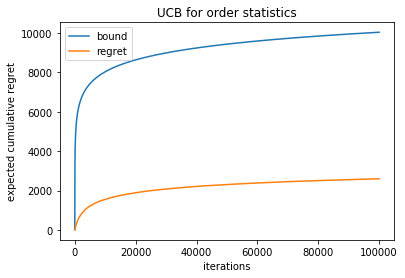

In [24]:
plt.plot(bounds, label = 'bound')
plt.plot(expected_regrets, label = 'regret')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('UCB for order statistics')
plt.legend()
plt.savefig('ucb_orderstat.png')

##  Gaussian Distribution

Although it hasn't been proved, but I am curious about how the experiment goes if the we allow the values from the gaussian distribution is negative. We take the same setting as above expect the sample distribution is normal distribution instead of absolute normal distribution (folded normal distribution).

In [25]:
class Normal_Environment():
    """Environment for distribution reward of arms.
    """
    def __init__(self, loc=0.0, scale=1.0, skewness = 0.0):
        self.loc = loc
        self.scale = scale
        self.skewness = skewness

    """
    def sample(self):
        uniformly generate x (between 0 and 1), 
           generate normal or skewed normal samples
        
        sigma = self.skewness/np.sqrt(1.0 + self.skewness**2) 
        u0,v = np.random.randn(2)
        u1 = sigma*u0 + np.sqrt(1.0-sigma**2) * v 
        if u0 >= 0:
            return u1*self.scale + self.loc
        return (-u1)*self.scale + self.loc 
    """

    def sample(self):
        return np.random.normal(self.loc, self.scale)

In [32]:
num_arms = 3
num_rounds = 100000
num_exper = 100
bestarm = 1
rewards_env = []
medians = []

for i in range(num_arms):
    # rewards distribution of arms is gaussian distribution with 
    # mean as i, variance as 1.
    rewards_env.append(Normal_Environment(loc = i))
    # for normal distribution, median is just mean 
    medians.append(i)

In [33]:
regrets = []

for i in range(num_exper):
    agent = UCB_os(rewards_env, num_rounds, medians)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets = np.mean(regrets, axis = 0)

In [34]:
def bound(num_arm, num_round, medians):
    bound = 0
    best_arm = np.argmax(medians)
    for i in range(num_arm):
        delta = medians[best_arm] - medians[i]
        beta = (64+32 * np.sqrt(2 * np.log(2))  * delta) * np.log(num_round)
        if i != best_arm:
            bound += (np.sqrt(beta) + 8 * np.sqrt(np.log(num_round)))**2 /(np.log(2) * delta) 
        bound+= (1+ np.pi**2/3) * delta
    return bound
        
bounds = []
for i in range(1, num_rounds):
    bounds.append(bound(num_arms, i, medians))

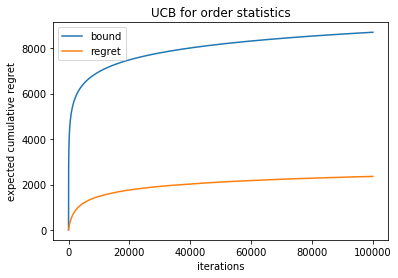

In [35]:
plt.plot(bounds, label = 'bound')
plt.plot(expected_regrets, label = 'regret')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('UCB for order statistics')
plt.legend()
#plt.savefig('ucb_orderstat.png')

From the regret plotting, the gaussian and abosulte gaussian has similar curve, which means the proof might also works for negative values. Both the cases have log regret and bound. 